In [2]:
#setup
data_dir='../../Data/Weather'
file_index='BBBBBSBS'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [3]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [4]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [5]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     27.4| 43.5914| -70.2989|       SNWD|USC00177523|    12|[00 7E 00 7E 00 7...|1997.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     0|[28 5D C4 5C C4 5...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     1|[C0 5E 58 5E C0 5...|1976.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     0|[5C 5C F0 5B F0 5...|1977.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     1|[58 5E 24 5F F0 5...|1978.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

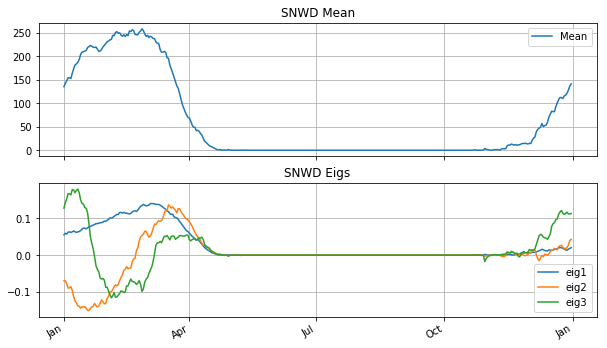

In [8]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [9]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]
v.shape

(365, 3)

### plot the percent of residual variance on average

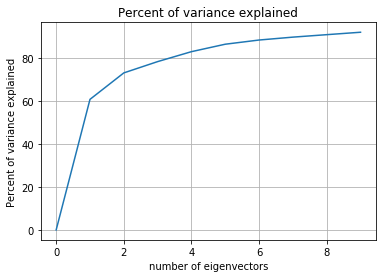

In [10]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

In [11]:
cumvar[:6]

array([  0.        ,  60.76639313,  73.0811533 ,  78.33589818,
        82.96430008,  86.43204581])

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [12]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [13]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)
df2.show(5)
#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|-1687.0846817160398|401.47275248495976| -84.69078428505608|     27.4|BBBBBSBS| 43.5914| -70.2989|       SNWD|0.32018776470376165|0.28846492900697357|0.28769198446304384|  2.964110840248255|USC00177523|  1272273.0|    12|[00 7E 00 7E 00 7...|1997.0|


In [13]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [14]:
def plot_decomp(row,Mean,v,coef_i,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s=%f, %s=%f'%('c'+str(coef_i),row['coeff_'+str(coef_i)],'r'+str(coef_i),row['res_'+str(coef_i)])
        #Title='%s / %d    %s=%f, %s=%f'%(row['station'],row['year'],'c'+str(coef_i),row['coeff_'+str(coef_i)],'r'+str(coef_i),row['res_'+str(coef_i)])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,coef_i,column_n=4, row_n=1, figsize=(15,3)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,coef_i,fig=fig,ax=axes[j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [15]:
#df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(4)
df4.select('coeff_2','res_2').show(4)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
| -5398.540823138331|0.15880031674406975|
| -3891.010720433024|0.07520805622542123|
| -3251.604828596838|0.12990337334872054|
|-3013.6485172617968| 0.1321959846624267|
+-------------------+-------------------+
only showing top 4 rows



/Users/rafaliang/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


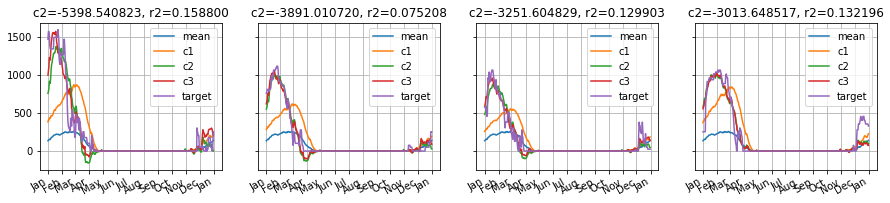

In [16]:
plot_recon_grid(rows,2)

In [19]:
df3.sort?

In [17]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(4)
df5.select('coeff_2','res_2').show(4)

+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
|3469.0152565378744|0.22002688940814827|
|3032.7764968515994|0.20065973837756726|
| 2806.172580434374|  0.173556248300797|
|2601.6636218331055|0.17704632526111286|
+------------------+-------------------+
only showing top 4 rows



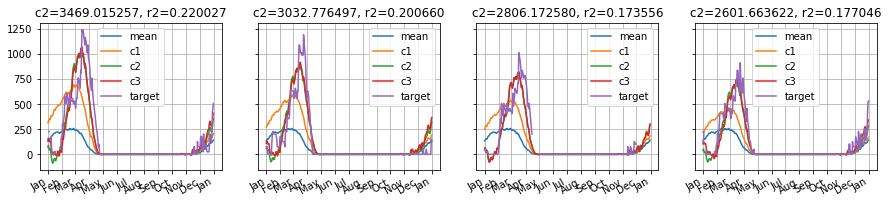

In [18]:
plot_recon_grid(rows,2)

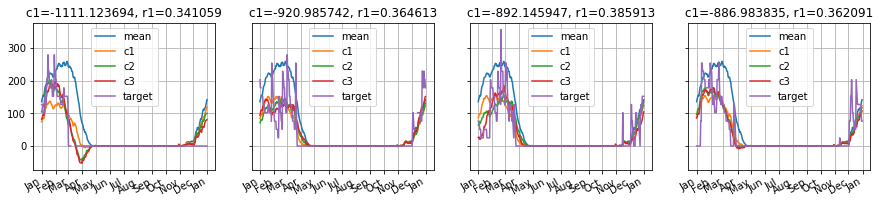

In [19]:
### coeff_1

df4=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
rows=df4.take(12)
#df4.select('coeff_2','res_2').show(4)
plot_recon_grid(rows,1)

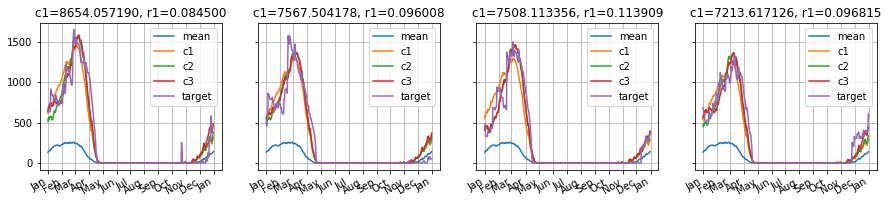

In [20]:
df4=df3.filter(df3.res_1<0.4).sort(df3.coeff_1,ascending=False)
rows=df4.take(12)
#df4.select('coeff_2','res_2').show(4)
plot_recon_grid(rows,1)

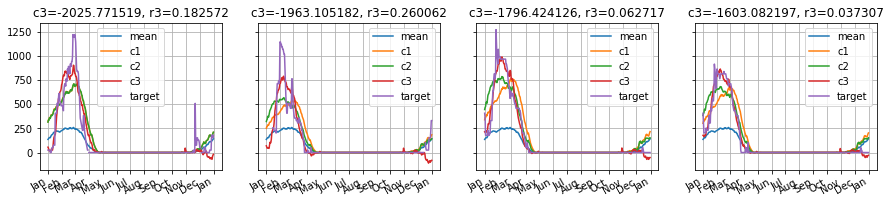

In [21]:
### coeff_3

df4=df3.filter(df3.res_3<0.4).sort(df3.coeff_3)
rows=df4.take(12)
#df4.select('coeff_2','res_2').show(4)
plot_recon_grid(rows,3)

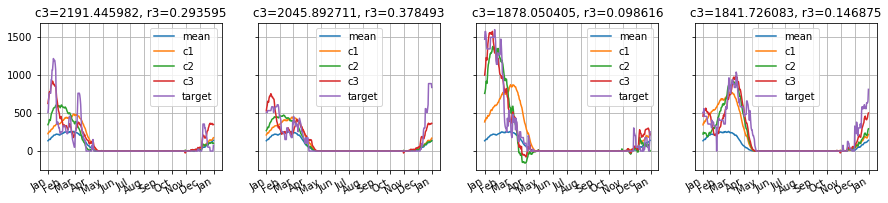

In [22]:
df4=df3.filter(df3.res_3<0.4).sort(df3.coeff_3,ascending=False)
rows=df4.take(12)
#df4.select('coeff_2','res_2').show(4)
plot_recon_grid(rows,3)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [ ]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [26]:
# A function for plotting the CDF of a given feature
def plot_CDF_coeff(featLst):
    column_n = len(featLst)
    fig,axes=plt.subplots(1,column_n, sharex='col', sharey='row',figsize=(12,3));
    for i in range(column_n):
        feat= featLst[i]
        rows=df3.select(feat).sort(feat).collect()
        vals=[r[feat] for r in rows]
        P=np.arange(0,1,1./(len(vals)))
        vals=[vals[0]]+vals
        ax=axes[i]
        ax.plot(vals,P)
        ax.set_title('cumulative distribution of '+feat)
        ax.set_ylabel('number of instances')
        ax.set_xlabel(feat)
        ax.grid()
        #plot(vals,P)
    
    plt.show()

In [28]:
def plot_CDF_res(featLst):
    column_n = len(featLst)
    #fig,axes=plt.subplots(1,column_n, sharex='col', sharey='row',figsize=(12,3));
    for i in range(column_n):
        feat= featLst[i]
        rows=df3.select(feat).sort(feat).collect()
        vals=[r[feat] for r in rows]
        P=np.arange(0,1,1./(len(vals)))
        vals=[vals[0]]+vals
        #ax=axes[i]
        plt.plot(vals,P,label=feat)
        
        #plot(vals,P)
    plt.grid()
    plt.title('cumulative distribution of residuals')
    plt.ylabel('number of instances')
    plt.xlabel('residual')
    plt.legend()
    plt.show()

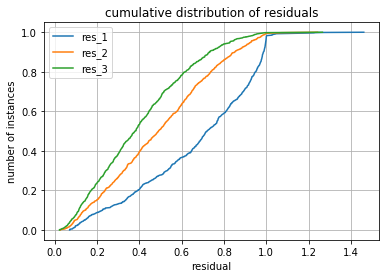

In [29]:
plot_CDF_res(['res_1','res_2','res_3'])

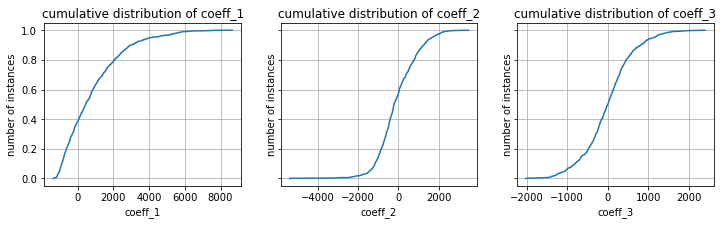

In [27]:
plot_CDF_coeff(['coeff_1','coeff_2','coeff_3'])

In [ ]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [ ]:
!du -sh $data_dir/*.parquet

In [ ]:
x1 = np.array([[1,2,3]])
x2 = np.array([[2,3,4]])
y = []
y.append(x1)
y.append(x2)
#np.dot(x1,x2.T)
#np.nansum(np.dstack((x1,x2)),axis=1)
np.vstack(y).shape

In [ ]:
'a'+str(1)